In [ ]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотеки для машинного обучения
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Настройки отображения
pd.set_option('display.max_columns', None)

# ================================
# Загрузка данных
# ================================

print("Загрузка данных из базы данных SQLite...")

# Подключение к базе данных SQLite
conn = sqlite3.connect('data/database.sqlite')

# Загрузка таблиц в DataFrame pandas
country = pd.read_sql_query("SELECT * FROM Country", conn)
league = pd.read_sql_query("SELECT * FROM League", conn)
match = pd.read_sql_query("SELECT * FROM Match", conn)
player = pd.read_sql_query("SELECT * FROM Player", conn)
player_attributes = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
team = pd.read_sql_query("SELECT * FROM Team", conn)
team_attributes = pd.read_sql_query("SELECT * FROM Team_Attributes", conn)

print("Данные успешно загружены.")

# Закрытие соединения с базой данных
conn.close()

# Отображение базовой информации
print(f"Количество матчей: {match.shape[0]}")
print(f"Количество команд: {team.shape[0]}")
print(f"Количество игроков: {player.shape[0]}")

# ================================
# Предварительная обработка и объединение данных
# ================================

# Объединение данных о странах и лигах с данными о матчах
match = match.merge(country, how='left', left_on='country_id', right_on='id', suffixes=('', '_country'))
match = match.merge(league, how='left', left_on='league_id', right_on='id', suffixes=('', '_league'))

# Переименование колонок для ясности
match.rename(columns={'name': 'country_name', 'name_league': 'league_name'}, inplace=True)

# Преобразование столбцов с датами в формат datetime
match['date'] = pd.to_datetime(match['date'])
team_attributes['date'] = pd.to_datetime(team_attributes['date'])
player_attributes['date'] = pd.to_datetime(player_attributes['date'])
player['birthday'] = pd.to_datetime(player['birthday'])

# Создание переменной исхода матча
# 1 - победа домашней команды, 0 - ничья, -1 - победа гостевой команды
def get_match_result(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return 1  # Победа дома
    elif row['home_team_goal'] == row['away_team_goal']:
        return 0  # Ничья
    else:
        return -1  # Победа в гостях

match['match_result'] = match.apply(get_match_result, axis=1)

# ================================
# Инженерия признаков
# ================================

# --- Атрибуты команд ---

# Определение колонок для использования из team_attributes
team_attribute_cols = [
    'buildUpPlaySpeed', 'buildUpPlayPassing', 'chanceCreationPassing',
    'chanceCreationCrossing', 'chanceCreationShooting', 'defencePressure',
    'defenceAggression', 'defenceTeamWidth', 'buildUpPlayPositioningClass',
    'chanceCreationPositioningClass', 'defenceDefenderLineClass'
]

# Подготовка атрибутов команды, выбирая наиболее актуальные перед датой матча
def get_team_attributes(team_id, match_date):
    attributes = team_attributes[team_attributes['team_api_id'] == team_id]
    attributes = attributes[attributes['date'] <= match_date]
    attributes = attributes.sort_values(by='date', ascending=False)
    if not attributes.empty:
        attributes = attributes.iloc[0]
        return attributes[team_attribute_cols]
    else:
        # Возврат Series с NaN и правильным индексом
        return pd.Series([np.nan]*len(team_attribute_cols), index=team_attribute_cols)

# Применение функции для получения атрибутов домашней и гостевой команд
print("Извлечение атрибутов команд...")
home_team_attrs = []
away_team_attrs = []

for idx, row in match.iterrows():
    home_attrs = get_team_attributes(row['home_team_api_id'], row['date'])
    away_attrs = get_team_attributes(row['away_team_api_id'], row['date'])
    home_team_attrs.append(home_attrs)
    away_team_attrs.append(away_attrs)

home_team_attrs_df = pd.DataFrame(home_team_attrs)
away_team_attrs_df = pd.DataFrame(away_team_attrs)

# Добавление префиксов к колонкам для различения атрибутов домашней и гостевой команд
home_team_attrs_df = home_team_attrs_df.add_prefix('home_')
away_team_attrs_df = away_team_attrs_df.add_prefix('away_')

# Объединение атрибутов с данными о матчах
match = pd.concat([match.reset_index(drop=True), home_team_attrs_df.reset_index(drop=True), away_team_attrs_df.reset_index(drop=True)], axis=1)

# Проверка на дублирующиеся колонки
duplicate_columns = match.columns[match.columns.duplicated()]
if duplicate_columns.any():
    print(f"Дублирующиеся колонки в DataFrame матчей: {duplicate_columns}")

# --- Атрибуты игроков ---

# Функция для получения средних атрибутов игроков команды до матча
def get_team_player_attributes(team_id, match_date, player_cols, match_row, team_type):
    # Получаем ID игроков из состава команды в матче
    players = []
    for i in range(1, 12):
        player_id = match_row.get(f'{team_type}_player_{i}', None)
        if not pd.isnull(player_id):
            players.append(player_id)
    # Получаем самые последние атрибуты для каждого игрока
    player_attrs = player_attributes[player_attributes['player_api_id'].isin(players)]
    player_attrs = player_attrs[player_attrs['date'] <= match_date]
    player_attrs = player_attrs.sort_values(by='date', ascending=False).drop_duplicates(subset=['player_api_id'], keep='first')
    # Возвращаем средние атрибуты
    if not player_attrs.empty:
        return player_attrs[player_cols].mean()
    else:
        # Возвращаем серию с NaN и правильным индексом
        return pd.Series([np.nan]*len(player_cols), index=player_cols)

print("Извлечение атрибутов игрока (это может занять некоторое время)...")
team_player_attrs = []

# Определим столбцы атрибутов игроков для использования
player_cols = [
    'overall_rating', 'potential', 'crossing', 'finishing', 'heading_accuracy',
    'short_passing', 'dribbling', 'long_passing', 'ball_control',
    'acceleration', 'sprint_speed', 'agility', 'stamina', 'strength',
    'penalties', 'marking', 'standing_tackle', 'sliding_tackle'
]

# Мы расширили атрибуты игроков, добавив больше признаков

for idx, row in match.iterrows():
    home_player_attrs = get_team_player_attributes(row['home_team_api_id'], row['date'], player_cols, row, 'home')
    away_player_attrs = get_team_player_attributes(row['away_team_api_id'], row['date'], player_cols, row, 'away')
    home_player_attrs = home_player_attrs.add_prefix('home_player_')
    away_player_attrs = away_player_attrs.add_prefix('away_player_')
    combined_attrs = pd.concat([home_player_attrs, away_player_attrs], axis=0)
    team_player_attrs.append(combined_attrs)

team_player_attrs_df = pd.DataFrame(team_player_attrs)

# Объединяем атрибуты игроков с данными о матчах
match = pd.concat([match.reset_index(drop=True), team_player_attrs_df.reset_index(drop=True)], axis=1)

# --- Недавние результаты команды ---

# Функция для вычисления недавних результатов команды до матча
def get_recent_performance(team_id, date, n_matches=5):
    team_matches_home = match[(match['home_team_api_id'] == team_id) & (match['date'] < date)]
    team_matches_away = match[(match['away_team_api_id'] == team_id) & (match['date'] < date)]
    team_matches = pd.concat([team_matches_home, team_matches_away]).sort_values(by='date', ascending=False)
    team_matches = team_matches.head(n_matches)
    if not team_matches.empty:
        results = []
        for idx, row in team_matches.iterrows():
            if row['home_team_api_id'] == team_id:
                if row['match_result'] == 1:
                    results.append(1)
                elif row['match_result'] == 0:
                    results.append(0)
                else:
                    results.append(-1)
            else:
                if row['match_result'] == -1:
                    results.append(1)
                elif row['match_result'] == 0:
                    results.append(0)
                else:
                    results.append(-1)
        return np.mean(results)
    else:
        return 0

print("Вычисление недавних результатов команды...")
home_recent_performance = []
away_recent_performance = []

for idx, row in match.iterrows():
    home_perf = get_recent_performance(row['home_team_api_id'], row['date'])
    away_perf = get_recent_performance(row['away_team_api_id'], row['date'])
    home_recent_performance.append(home_perf)
    away_recent_performance.append(away_perf)

match['home_recent_performance'] = home_recent_performance
match['away_recent_performance'] = away_recent_performance

# --- Статистика личных встреч ---

# Функция для вычисления статистики личных встреч
def get_head_to_head(home_team_id, away_team_id, date):
    h2h_matches = match[((match['home_team_api_id'] == home_team_id) & (match['away_team_api_id'] == away_team_id)) |
                        ((match['home_team_api_id'] == away_team_id) & (match['away_team_api_id'] == home_team_id))]
    h2h_matches = h2h_matches[h2h_matches['date'] < date].sort_values(by='date', ascending=False)
    h2h_matches = h2h_matches.head(5)
    if not h2h_matches.empty:
        results = []
        for idx, row in h2h_matches.iterrows():
            if row['home_team_api_id'] == home_team_id and row['match_result'] == 1:
                results.append(1)
            elif row['away_team_api_id'] == home_team_id and row['match_result'] == -1:
                results.append(1)
            elif row['match_result'] == 0:
                results.append(0)
            else:
                results.append(-1)
        return np.mean(results)
    else:
        return 0

print("Вычисление статистики личных встреч...")
h2h_performance = []

for idx, row in match.iterrows():
    h2h_perf = get_head_to_head(row['home_team_api_id'], row['away_team_api_id'], row['date'])
    h2h_performance.append(h2h_perf)

match['head_to_head'] = h2h_performance

# --- Категориальное кодирование ---

# Исправлены имена столбцов (изменили 'defenceDefensiveLineClass' на 'defenceDefenderLineClass')
categorical_cols = [
    'home_buildUpPlayPositioningClass', 'home_chanceCreationPositioningClass', 'home_defenceDefenderLineClass',
    'away_buildUpPlayPositioningClass', 'away_chanceCreationPositioningClass', 'away_defenceDefenderLineClass'
]

# Заменяем пропущенные категориальные значения на заглушку
for col in categorical_cols:
    if col in match.columns:
        match[col].fillna('Unknown', inplace=True)
        match[col] = match[col].astype('category').cat.codes

# --- Выбор признаков ---

# Выбираем важные признаки
features = [
    # Атрибуты команды
    'home_buildUpPlaySpeed', 'home_buildUpPlayPassing', 'home_chanceCreationPassing',
    'home_chanceCreationCrossing', 'home_chanceCreationShooting', 'home_defencePressure',
    'home_defenceAggression', 'home_defenceTeamWidth',
    'away_buildUpPlaySpeed', 'away_buildUpPlayPassing', 'away_chanceCreationPassing',
    'away_chanceCreationCrossing', 'away_chanceCreationShooting', 'away_defencePressure',
    'away_defenceAggression', 'away_defenceTeamWidth',
    # Атрибуты игроков
    'home_player_overall_rating', 'home_player_potential', 'home_player_crossing',
    'home_player_finishing', 'home_player_heading_accuracy', 'home_player_short_passing',
    'home_player_dribbling', 'home_player_long_passing', 'home_player_ball_control',
    'home_player_acceleration', 'home_player_sprint_speed', 'home_player_agility',
    'home_player_stamina', 'home_player_strength', 'home_player_penalties',
    'home_player_marking', 'home_player_standing_tackle', 'home_player_sliding_tackle',
    'away_player_overall_rating', 'away_player_potential', 'away_player_crossing',
    'away_player_finishing', 'away_player_heading_accuracy', 'away_player_short_passing',
    'away_player_dribbling', 'away_player_long_passing', 'away_player_ball_control',
    'away_player_acceleration', 'away_player_sprint_speed', 'away_player_agility',
    'away_player_stamina', 'away_player_strength', 'away_player_penalties',
    'away_player_marking', 'away_player_standing_tackle', 'away_player_sliding_tackle',
    # Недавние результаты
    'home_recent_performance', 'away_recent_performance',
    # Личные встречи
    'head_to_head',
    # Категориальные признаки
    'home_buildUpPlayPositioningClass', 'home_chanceCreationPositioningClass', 'home_defenceDefenderLineClass',
    'away_buildUpPlayPositioningClass', 'away_chanceCreationPositioningClass', 'away_defenceDefenderLineClass'
]

# Проверяем, что все признаки есть в DataFrame
existing_features = [col for col in features if col in match.columns]
missing_features = [col for col in features if col not in match.columns]
if missing_features:
    print(f"Отсутствуют следующие признаки, которые будут исключены: {missing_features}")

# Убираем строки с пропущенными значениями в признаках или целевой переменной
print("Очищаем данные, удаляя строки с пропущенными значениями в выбранных признаках...")
match_cleaned = match.dropna(subset=existing_features + ['match_result'])
print(f"Размер данных до очистки: {match.shape[0]} строк")
print(f"Размер данных после очистки: {match_cleaned.shape[0]} строк")

X = match_cleaned[existing_features]
y = match_cleaned['match_result']

# Преобразуем целевую переменную в числовые классы (0,1,2)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Работа с несбалансированными классами с использованием SMOTE
print("Работа с несбалансированными классами с помощью SMOTE...")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_encoded)

# ================================
# Обучение модели и оценка
# ================================

# Разделение данных на обучающую и тестовую выборки
print("Разделение данных на обучающую и тестовую выборки...")
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# Определение моделей для обучения
models = {
    'Логистическая регрессия': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Метод опорных векторов': SVC(probability=True, class_weight='balanced'),
    'Случайный лес': RandomForestClassifier(class_weight='balanced'),
    'Градиентный бустинг': GradientBoostingClassifier(),
    'К-ближайших соседей': KNeighborsClassifier(),
    'Нейронная сеть': MLPClassifier(max_iter=1000),
    'Extra Trees': ExtraTreesClassifier(class_weight='balanced'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

# Обучение моделей и оценка качества
print("\nОбучение моделей и оценка качества...")
results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\nОбучение модели {name}...")
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    print(f"{name} Точность перекрестной проверки: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Точность теста: {acc:.4f}")
    results[name] = acc

# Вывод моделей, отсортированных по тестовой точности
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print("\nМодели, отсортированные по тестовой точности:")
for name, acc in sorted_results:
    print(f"{name}: {acc:.4f}")

# ================================
# Настройка гиперпараметров для лучшей модели
# ================================

# Предположим, что XGBoost показал лучший результат
best_model_name = sorted_results[0][0]
print(f"\nНастройка гиперпараметров для {best_model_name}...")

if best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [6, 10],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.8, 1]
    }
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
elif best_model_name == 'LightGBM':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [6, 10, -1],
        'learning_rate': [0.01, 0.1],
        'num_leaves': [31, 50],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.8, 1]
    }
    model = LGBMClassifier()
elif best_model_name == 'CatBoost':
    param_grid = {
        'iterations': [500, 1000],
        'depth': [6, 10],
        'learning_rate': [0.01, 0.1],
        'l2_leaf_reg': [1, 3, 5]
    }
    model = CatBoostClassifier(verbose=0)
else:
    # Для других моделей используются общие параметры
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    model = models[best_model_name]

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Лучшие параметры для {best_model_name}: {grid_search.best_params_}")

# Оценка лучшей модели
print(f"\nОценка лучшей модели {best_model_name} Model...")
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_.astype(str)))
print(f"Точность: {accuracy_score(y_test, y_pred):.4f}")

# ================================
# Прогноз на новых данных
# ================================

# Для демонстрации предскажем результат следующего матча в наборе данных
print("\nПрогнозирование результата для нового матча...")

# Предположим, что следующий матч находится по индексу -1
new_match = match_cleaned.iloc[-1]

# Подготовка вектор признаков
new_match_features = new_match[existing_features].values.reshape(1, -1)
new_match_scaled = scaler.transform(new_match_features)

# Прогнозирование с использованием лучшей модели
prediction = best_model.predict(new_match_scaled)
result = label_encoder.inverse_transform(prediction)[0]
outcome = {1: 'Победа хозяев', 0: 'Ничья', -1: 'Away Win'}

print(f"Предсказанный результат: {outcome[result]}")

# ================================
# Заключение
# ================================

print("\nВыполнение ноутбука завершено успешно.")

Загрузка данных из базы данных SQLite...
Данные успешно загружены.
Количество матчей: 25979
Количество команд: 299
Количество игроков: 11060
Извлечение атрибутов команд...
Извлечение атрибутов игрока (это может занять некоторое время)...
Вычисление недавних результатов команды...
Вычисление статистики личных встреч...
Очищаем данные, удаляя строки с пропущенными значениями в выбранных признаках...
Размер данных до очистки: 25979 строк
Размер данных после очистки: 19355 строк
Работа с несбалансированными классами с помощью SMOTE...
Разделение данных на обучающую и тестовую выборки...

Обучение моделей и оценка качества...

Обучение модели Логистическая регрессия...
Логистическая регрессия Точность перекрестной проверки: 0.4634 (+/- 0.0077)
Логистическая регрессия Точность теста: 0.4697

Обучение модели Метод опорных векторов...


Описательная статистика для числовых признаков:
       home_buildUpPlaySpeed  home_buildUpPlayPassing  \
count           19355.000000             19355.000000   
mean               52.470421                47.926892   
std                11.926898                11.102484   
min                20.000000                20.000000   
25%                45.000000                39.000000   
50%                53.000000                49.000000   
75%                62.000000                55.000000   
max                80.000000                80.000000   

       home_chanceCreationPassing  home_chanceCreationCrossing  \
count                19355.000000                 19355.000000   
mean                    52.418962                    54.067941   
std                     10.434212                    11.205949   
min                     21.000000                    20.000000   
25%                     47.000000                    48.000000   
50%                     52.000000         

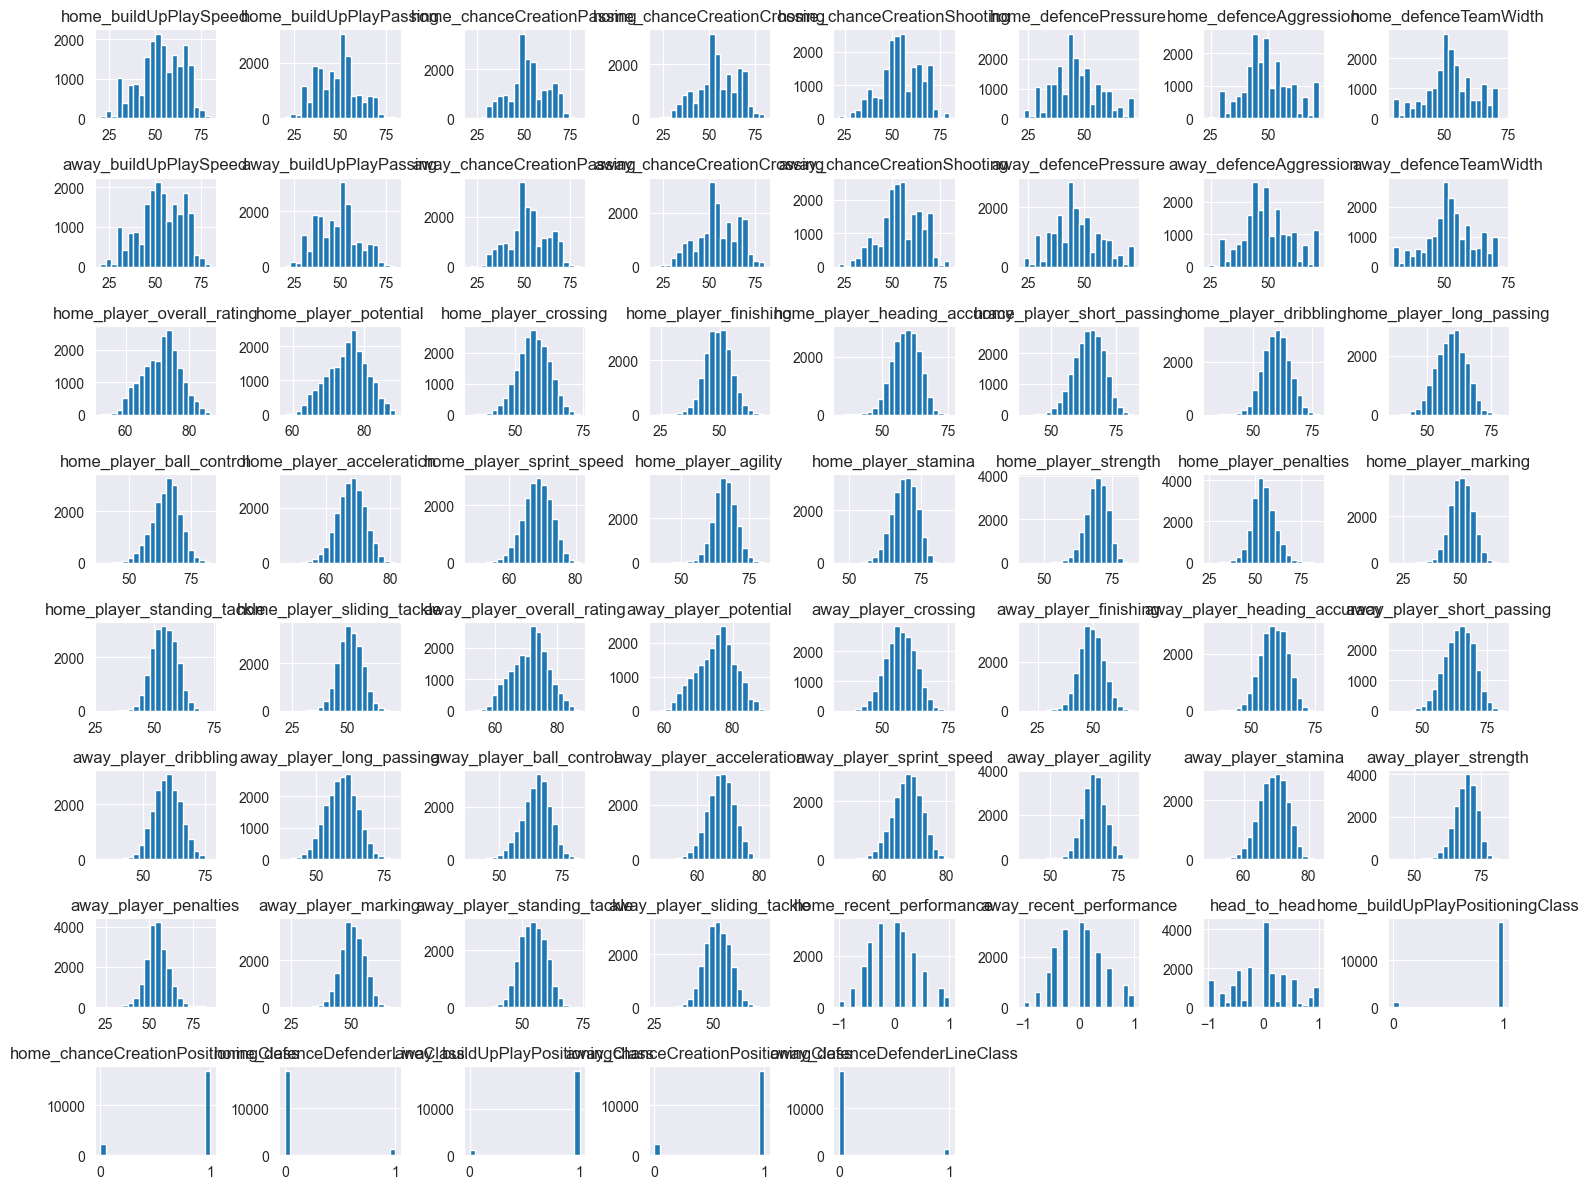

Корреляционный анализ между признаками...
                                     home_buildUpPlaySpeed  \
home_buildUpPlaySpeed                             1.000000   
home_buildUpPlayPassing                           0.411975   
home_chanceCreationPassing                        0.301306   
home_chanceCreationCrossing                       0.189292   
home_chanceCreationShooting                       0.083149   
...                                                    ...   
home_chanceCreationPositioningClass               0.013293   
home_defenceDefenderLineClass                    -0.082752   
away_buildUpPlayPositioningClass                  0.019906   
away_chanceCreationPositioningClass              -0.005781   
away_defenceDefenderLineClass                    -0.050299   

                                     home_buildUpPlayPassing  \
home_buildUpPlaySpeed                               0.411975   
home_buildUpPlayPassing                             1.000000   
home_chanceCreationPa

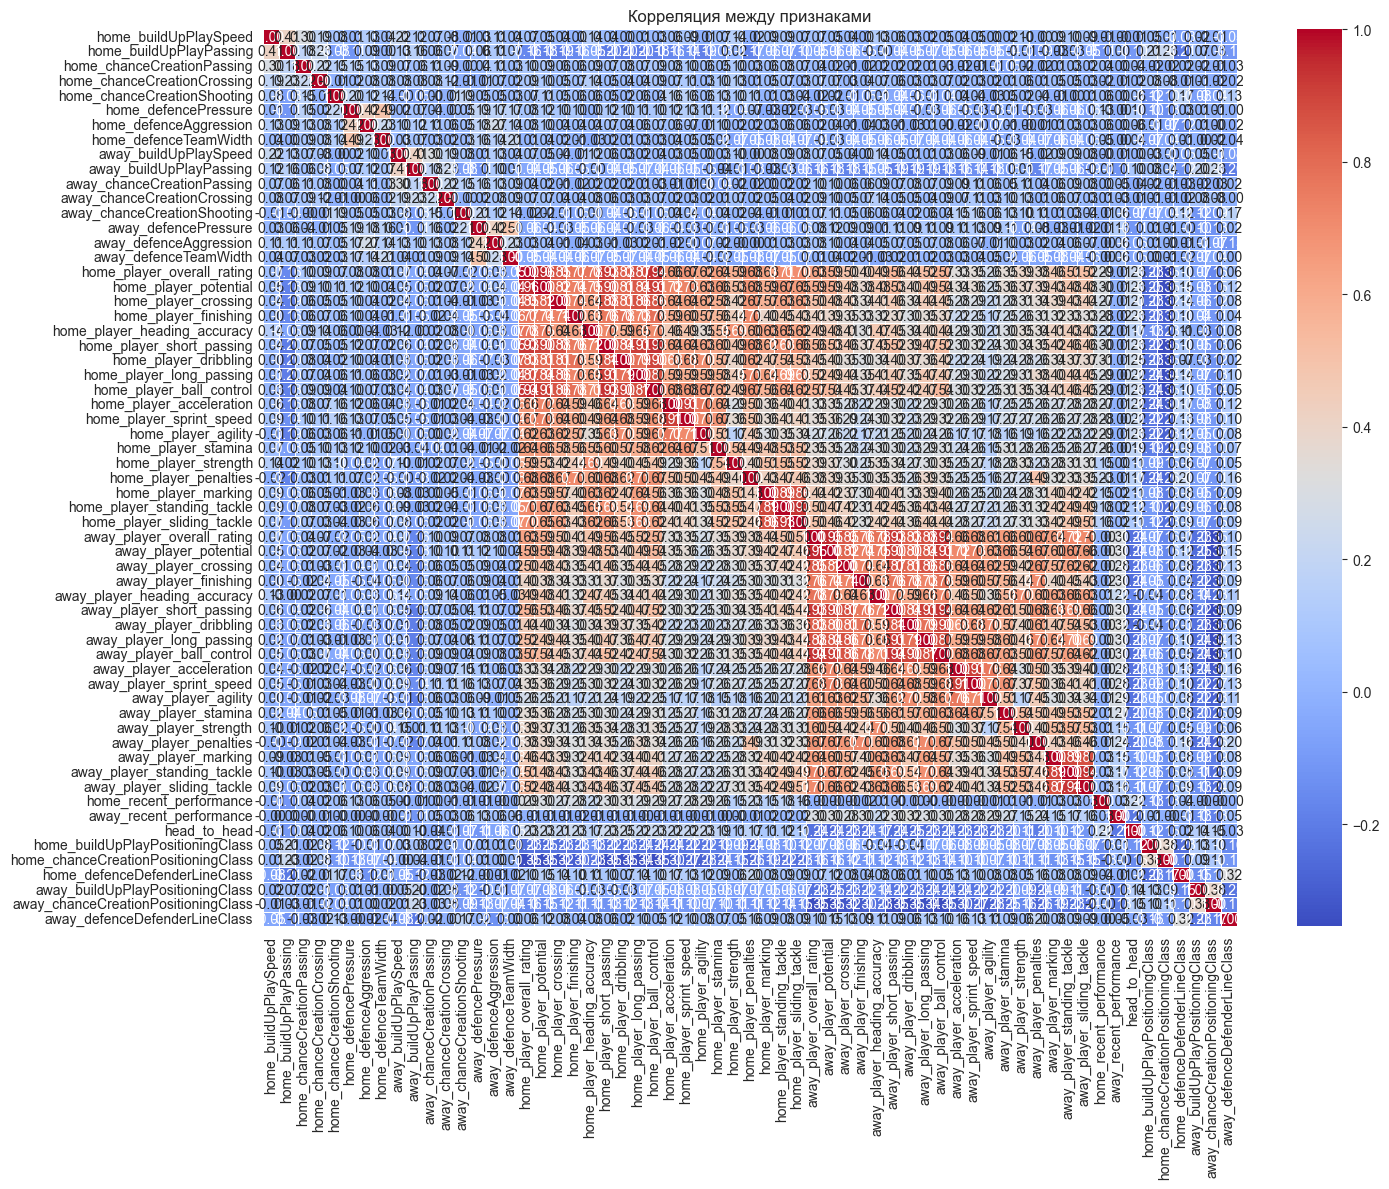

Корреляция с целевой переменной (match_result):
home_buildUpPlaySpeed                 -0.012016
home_buildUpPlayPassing               -0.064375
home_chanceCreationPassing             0.024777
home_chanceCreationCrossing            0.008543
home_chanceCreationShooting            0.043991
                                         ...   
home_defenceDefenderLineClass          0.038255
away_buildUpPlayPositioningClass       0.063910
away_chanceCreationPositioningClass    0.091550
away_defenceDefenderLineClass         -0.008765
match_result                           1.000000
Name: match_result, Length: 62, dtype: float64


In [7]:
# Статистический анализ
print("Описательная статистика для числовых признаков:")
desc_stats = match_cleaned[existing_features].describe()
print(desc_stats)

# Визуализация распределений для каждого признака
print("Построение гистограмм для признаков...")
match_cleaned[existing_features].hist(figsize=(15, 12), bins=20)
plt.tight_layout()
plt.show()

# Корреляционный анализ
print("Корреляционный анализ между признаками...")

# Расчет корреляции Пирсона
correlation_matrix = match_cleaned[existing_features].corr()
print(correlation_matrix)

# Визуализация матрицы корреляции с использованием тепловой карты
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Корреляция между признаками')
plt.tight_layout()
plt.show()

# Если вы хотите проверить корреляцию для целевой переменной
print("Корреляция с целевой переменной (match_result):")
target_correlation = match_cleaned[existing_features + ['match_result']].corr()['match_result']
print(target_correlation)


In [14]:
# Saving the cleaned match data to a CSV file
match_cleaned.to_csv('football_match_predictions.csv', index=False)


player_attributes.csv успешно создан.
team_attributes.csv успешно создан.


In [ ]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Вы можете записать до 20 ГБ данных в текущую директорию (/kaggle/working/),
# и они сохранятся как результат при создании версии через "Save & Run All".


# Вы также можете записывать временные файлы в /kaggle/temp/, но они не сохранятся за пределами текущей сессии.
# Импорты

import numpy as np  # линейная алгебра
import pandas as pd  # обработка данных, работа с CSV-файлами
import sqlite3  # работа с базами данных SQLite
import matplotlib.pyplot as plt  # библиотека для построения графиков

# Файлы входных данных доступны в директории "../input/".
# Например, выполнение этого кода (нажав "Run" или Shift+Enter) выведет список файлов в директории input.


conn = sqlite3.connect("data/database.sqlite")  # подключение к базе данных SQLite

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)  # запрос списка таблиц в базе данных
tables  # вывод таблиц


# Загрузка каждой таблицы в DataFrame библиотеки pandas
player_attributes = pd.read_sql("SELECT * FROM Player_Attributes", conn)  # таблица атрибутов игроков
player = pd.read_sql("SELECT * FROM Player", conn)  # таблица игроков
match = pd.read_sql("SELECT * FROM Match", conn)  # таблица матчей
league = pd.read_sql("SELECT * FROM League", conn)  # таблица лиг
country = pd.read_sql("SELECT * FROM Country", conn)  # таблица стран
team = pd.read_sql("SELECT * FROM Team", conn)  # таблица команд
team_attributes = pd.read_sql("SELECT * FROM Team_Attributes", conn)  # таблица атрибутов команд

# Просмотр первых нескольких строк каждого DataFrame
print(player_attributes.head())  # вывод первых строк таблицы Player_Attributes
print(player.head())  # вывод первых строк таблицы Player
print(match.head())  # вывод первых строк таблицы Match
print(league.head())  # вывод первых строк таблицы League
print(country.head())  # вывод первых строк таблицы Country
print(team.head())  # вывод первых строк таблицы Team
print(team_attributes.head())  # вывод первых строк таблицы Team_Attributes


# Сводная статистика
print(player_attributes.describe())  # вывод статистики для таблицы Player_Attributes
print(team_attributes.describe())  # вывод статистики для таблицы Team_Attributes

# Построение гистограмм (распределений)
player_attributes['overall_rating'].hist(bins=20)  # гистограмма для общего рейтинга игроков
plt.title('Распределение общего рейтинга игроков')  # заголовок графика
plt.xlabel('Общий рейтинг')  # подпись оси X
plt.ylabel('Частота')  # подпись оси Y
plt.show()  # отображение графика

team_attributes['buildUpPlaySpeed'].hist(bins=20)  # гистограмма для скорости построения игры команды
plt.title('Распределение скорости построения игры команд')  # заголовок графика
plt.xlabel('Скорость построения игры')  # подпись оси X
plt.ylabel('Частота')  # подпись оси Y
plt.show()  # отображение графика


# Базовый анализ исходов матчей
print(match[['home_team_goal', 'away_team_goal']].describe())  # описательная статистика по голам

# Среднее количество голов за матч
average_goals = match[['home_team_goal', 'away_team_goal']].mean().sum()  # среднее по домашним и гостевым голам
print(f'Среднее количество голов за матч: {average_goals}')

# Распределение общего количества голов в матчах
match['total_goals'] = match['home_team_goal'] + match['away_team_goal']  # вычисляем общее количество голов
match['total_goals'].hist(bins=20)  # строим гистограмму распределения общего количества голов
plt.title('Распределение общего количества голов за матч')  # заголовок графика
plt.xlabel('Общее количество голов')  # подпись оси X
plt.ylabel('Частота')  # подпись оси Y
plt.show()  # отображение графика